In [1]:
import xarray
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import pandas as pd
import dictionaries
import cartopy.crs as ccrs
import cmocean
import matplotlib
import string
import mapplotting
import geopandas as gp
import methane_utils as mutils

S_lim = 53.5
N_lim = 60
W_lim = 10
E_lim = 20

pc = cartopy.crs.PlateCarree()
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean((W_lim, E_lim)),
                                  central_latitude=np.mean((S_lim, N_lim)))

# compute distance from the leak sites:
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1)
                  * np.cos(lat2) * np.cos(lon1 - lon2))
    )

In [2]:
bathy = xarray.open_dataset("../data/input/BAL-MFC_003_006_mask_bathy.nc")
bathy = bathy#.sel(longitude=slice(10,20), latitude=slice(53,60.02), drop=True)
coordinates = xarray.open_dataset("../data/input/BAL-MFC_003_006_coordinates.nc")
coordinates['areas'] = coordinates.e1t*coordinates.e2t
coordinates['volumes'] = coordinates.e3t*coordinates.e2t*coordinates.e1t
subbasins = 'level_2'
mask = bathy['mask'].values.astype(int)
coordinates['volumes'] = coordinates['volumes'].where(mask)

runnumber = str(194)
#ds = xarray.open_mfdataset(f'../data/output/{runnumber}_histogram_calibration.nc', chunks=dict(time=10))
ds = xarray.open_mfdataset(f'../data/output/{runnumber}_histogram.nc', chunks=dict(time=10))
#ds = ds.isel(time=slice(0,-1,10), drop=True) # use this for speedup or approximation

volumes = coordinates['volumes'].rename(
    dict(
        latitude='lat_bin', 
        longitude='lon_bin',
        depth='z_bin'))
ds['volumes'] = (('z_bin', 'lat_bin', 'lon_bin'), volumes.values) # keep this way!
ds['concentration'] = ds.mass/ds.volumes # [in ug/m3]
ds['concentration'] = ds['concentration']*1e-6/16.04*1e-3
ds['concentration_zmean'] = ds['mass_zsum']*1e-6/16.04*1e-3/ds.volumes.sum(dim='z_bin')
h = ds['concentration_zmean']
df_helcom = gp.read_file("../data/input/_ags_HELCOM_subbasins_2022_level21/HELCOM_subbasins_2022_level2.shp")

In [4]:
def create_map_figure(fig, ax, zoomin=False, cbar=False, gridlines=True):
    pc, ax, gl = mapplotting.plot_concentrations_map(fig, ax, bathy=True, 
                                                     zoomin=zoomin, 
                                                     cbar=False,
                                                     gtrajectory=True, 
                                                     gridlines=True,
                                                     biglabels=False)
    return fig, ax, pc, gl

In [5]:
def create_2upper(fig, axs):

    runnumber = str(100)
    #ds = xarray.open_mfdataset(f'../data/output/{runnumber}_histogram_calibration.nc', chunks=dict(time=10))
    dstem = xarray.open_mfdataset(f'../data/output/{runnumber}_histogram.nc', chunks=dict(time=10))
    
    volumestem = coordinates['volumes'].rename(
        dict(
            latitude='lat_bin', 
            longitude='lon_bin',
            depth='z_bin'))
    dstem['volumes'] = (('z_bin', 'lat_bin', 'lon_bin'), volumes.values) # keep this way!
    dstem['concentration'] = dstem.mass/dstem.volumes # [in ug/m3]
    dstem['concentration'] = dstem['concentration']*1e-6/16.04*1e-3
    dstem['concentration_zmean'] = dstem['mass_zsum']*1e-6/16.04*1e-3/dstem.volumes.sum(dim='z_bin')
    htem = dstem['concentration_zmean']
    
    import matplotlib.ticker as mticker
    
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    ax4 = axs[3]
    
    helcom = False
    hatches = False
    background_map = True
    bathy = True

    plt_times = [np.datetime64('2022-10-05T02'), np.datetime64('2022-10-15T02'),
                 np.datetime64('2022-11-01T02'), np.datetime64('2022-12-01T02')]
    existing_times = htem.time.sel(time=plt_times, method='nearest', drop=True).values
    h_tss = htem.sel(time=existing_times, drop=True).compute()
    h_tss.values = h_tss.values
    vmin=1e-10
    vmax=1e-5

    for index, time in enumerate(existing_times):
        print('iteration', index)
        ax = axs[index]
        ax.set_title(pd.to_datetime(time).date(), y=1.0, fontsize=15, zorder=500)
        labels = True if index==0 else False
        if background_map:
            pc, ax, gl = mapplotting.plot_concentrations_map(fig, ax, bathy=bathy, cbar=False, labels=labels, 
                                                        gtrajectory=True, gridlines=False, biglabels=False)
            
            gl.xlocator = mticker.FixedLocator([12, 15, 18])
            gl.xlabel_style = {'color':'k', 'rotation':0}
            ax.set_extent((dictionaries.W_lim, dictionaries.E_lim, 
                           dictionaries.S_lim, dictionaries.N_lim), crs=pc)

        else:
            pc = cartopy.crs.PlateCarree()
            ax.set_extent((dictionaries.W_lim, dictionaries.E_lim, 
                           dictionaries.S_lim, dictionaries.N_lim), crs=pc)


        h_ts = h_tss.isel(time=index)
        print(h_ts.time.values)
        methane_c = ax.pcolormesh(
                    h_ts.lon_bin,
                    h_ts.lat_bin,
                    h_ts.values.T,
                    transform=pc,
                    cmap=cmocean.cm.amp,
                    zorder=1,
                    norm=matplotlib.colors.LogNorm(
                    vmin=vmin,
                    vmax=vmax,
                    )
        )

        if hatches:
            colors1 = ax.contourf(
                          h_ts.lon_bin,
                          h_ts.lat_bin,
                          h_ts.values.T,
                          transform=pc,
                          norm=matplotlib.colors.LogNorm(
                                    vmin=vmin,
                          ),
                          cmap='Reds',
                          levels=[1e-8, 1e-7, 1e-6, 1e-5],
                          hatches=['\\','///','xx'],
                          alpha=0.1,
                          zorder=3,
                          lw=0.3)

            # This is just to create black level lines
            colors1 = ax.contour(
                          h_ts.lon_bin,
                          h_ts.lat_bin,
                          h_ts.values.T,
                          transform=pc,
                          levels=[1e-8, 1e-7, 1e-6, 1e-5],
                          zorder=3,
                          colors='k',
                          lw=0.3)

        if helcom:
            mapplotting.plot_helcom(ax, df_helcom)

    cb = fig.colorbar(methane_c, ax=[ax1, ax2, ax3, ax4],#fig.axes, 
                      orientation='vertical', pad=0.01,
                 label='Methane conc [mol l⁻¹]', shrink=0.6)#, pad=-0.0005)

    if hatches:
        cb.ax.add_patch(
            matplotlib.patches.Rectangle((0,1e-8), 
                                  10, 
                                  9e-8,
                                  color='k', 
                                  hatch='\\',
                                  fill=False, 
                                  snap=True))    

        cb.ax.add_patch(
            matplotlib.patches.Rectangle((0,1e-7), 
                                  10, 
                                  9e-7,
                                  color='k', 
                                  hatch='///',
                                  fill=False, 
                                  snap=True))    

        cb.ax.add_patch(
            matplotlib.patches.Rectangle((0,1e-6), 
                                  10, 
                                  9e-6,
                                  color='k', 
                                  hatch='xx',
                                  fill=False, 
                                  snap=True)) 


In [6]:
def create_2lower(fig, axu, axl, degrationplot=False, surface=False, everythinggrey=False):
    from GliderTools import glidertools as gt
    import datetime

    dsg = xarray.open_mfdataset('../data/input/methane_processed_bastien/timeseries_output.nc')
    dsg['meantime'] = gt.utils.time_average_per_dive(dsg.profile_num, dsg.time)
    dsgud = dsg.where(dsg.profile_num.values%2==1).dropna(dim='time', subset=['depth'])
    if surface:
        dsgud = dsgud.where(dsgud.depth<20)
    dfgud = dsgud.to_pandas()
    means = dfgud.groupby('profile_num').mean()
    means['background'] = 10e-9#(mutils.compute_methane_equilibrium(means, 'surface')*1e-3).values

    axu.set_yscale('log')
    axu.set_ylabel('Methane conc [mol l⁻³]')
    axl.set_xlabel('date')
    axl.set_ylabel('dist. [km]')
    axu.grid()
    axu.set_xlim(datetime.datetime(2022,10,2), datetime.datetime(2023,1,5))
    
    
    
    from GliderTools import glidertools as gt

    datagaps = [(np.datetime64('2022-10-19T21:09:56.203000064'),
                  np.datetime64('2022-10-20T15:11:31.184999936')),
                 (np.datetime64('2022-10-31T12:51:32.377999872'),
                  np.datetime64('2022-11-01T08:39:31.153999872')),
                 (np.datetime64('2022-11-13T10:22:04.368000000'),
                  np.datetime64('2022-11-15T15:14:09.873999872')),
                 (np.datetime64('2022-11-25T12:27:18.000000000'),
                  np.datetime64('2022-11-26T09:02:23.486000128')),
                 (np.datetime64('2022-12-08T09:45:27.012000000'),
                  np.datetime64('2022-12-09T08:56:41.233999872')),
                 (np.datetime64('2022-12-16T14:17:58.043000064'),
                  np.datetime64('2022-12-17T10:12:01.003000064'))]

    for datagap in datagaps:
        axu.axvspan(datagap[0], datagap[1], color='lightgrey', zorder=1000)
        axl.axvspan(datagap[0], datagap[1], color='lightgrey', zorder=1000)
        
    ds['concentration_zmean'] = ds['concentration_zmean'].rolling(lon_bin=3, center=True).mean().rolling(lat_bin=3, center=True).mean()
    result = ds.drop_dims('z_bin')['concentration_zmean'].interp(
        time=means.meantime.to_xarray(),
        lon_bin=means.longitude.to_xarray(),
        lat_bin=means.latitude.to_xarray(),
        method='linear')

    result_w_background = result + means.background.values

    if everythinggrey:
        alpha=0.5
        color='tab:red'
        ferryboxmaxcolor='grey'
        ferryboxclosecolor='grey'
        ls = '-'
        glidercolor='grey'
        label = 'num. model'
        modelz=500
    
    elif degrationplot:
        color = rddict[looprunnumber]
        label = f'num. model {rdlabels[looprunnumber]} d⁻¹ oxidation'
        ls = rdlinestyles[looprunnumber]
        ferryboxmaxcolor='k'
        ferryboxclosecolor='green'
        glidercolor='tab:blue'
        alpha=1
        modelz=500
    else:
        color = 'tab:red'
        label = 'num. model'
        ls = '-'
        ferryboxmaxcolor='k'
        ferryboxclosecolor='green'
        glidercolor='tab:blue'
        alpha=1
        modelz=1

    if not degrationplot:
        axu.plot(means.meantime, 
                    means.methane*1e-6,
                    c=glidercolor, zorder=10, lw=2, 
                    alpha=0.5, label='Glider observations')
    
    axu.plot(result_w_background.time, 
                result_w_background,
                color=color,
                ls=ls,
                lw=2, label=label,
                zorder=modelz)
    
    distance = great_circle(dictionaries.leak3['lon'], dictionaries.leak3['lat'], means.longitude, means.latitude)
    axl.plot(means.meantime, distance, lw=3)
    axl.grid()
    
    if not degrationplot:
        ### this is lading and plotting the respective Ferry data on top ###
        import pandas
        df_ferry = pandas.read_csv(
            '../data/input/IOW_Ferry_box/IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_VOTO/'
            'IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_DLR.txt')
        df_ferry['time'] = pandas.to_datetime(df_ferry['MatlabTime']-719529, unit='D')
        df_ferry_close = df_ferry[(df_ferry.Lat>55.3) & (df_ferry.Lat<55.8) & (df_ferry.Lon>15.6) & (df_ferry.Lon<15.8)]

        df_ferry = df_ferry.dropna()
        df_ferry.drop(['MatlabTime', 'ExcelTime', 'Day', 'Month', 'Year', 'Hour', 'Minute'], axis=1)
        indices = df_ferry.groupby(df_ferry.time.dt.date)['cCH4is_nmol_l_corr'].idxmax()
        df_ferry_max = df_ferry.loc[indices.values]

        df_ferry_close = df_ferry_close.dropna()
        df_ferry_close.drop(['MatlabTime', 'ExcelTime', 'Day', 'Month', 'Year', 'Hour', 'Minute'], axis=1)
        indices = df_ferry_close.groupby(df_ferry_close.time.dt.date)['cCH4is_nmol_l_corr'].idxmax()
        df_ferry_close_max = df_ferry.loc[indices.values]    
        axu.scatter(df_ferry_max.time , df_ferry_max.cCH4is_nmol_l_corr*1e-9, 
                       s=100, c=ferryboxmaxcolor, label='SPOOP (daily max.)', zorder=50, alpha=alpha)
        axu.scatter(df_ferry_close_max.time , df_ferry_close_max.cCH4is_nmol_l_corr*1e-9, 
                       s=100, c=ferryboxclosecolor, label='SPOOP (closest to Glider)', zorder=50, alpha=alpha)
        ### end Ferry data ###

    axu.legend(loc='upper right').set_zorder(1001)
    return axu


"\n    #axs[0].plot(result_ferry.time,\n    #            result_ferry.)\n\n    for time in means.time.values[mins]:\n        axl.axvline(x=time, color='tab:purple', alpha=0.5)\n    for time in means.time.values[maxs]:\n        axl.axvline(x=time, color='tab:green', alpha=0.5)\n\n\n    # plot ferry box \n    axs[0].scatter(df_ferry.index, df_ferry.cCH4is_nmol_l_corr*1e-6/1e-3, label='Ferry box', color='orange')\n    axs[0].scatter(result_w_ferry_background.time, \n                result_w_ferry_background*1e6/1e3,\n                #result.values.clip(min=3e-6), \n                color='k', \n                lw=2, label='ferry box num')\n\n#plt.axvline(x=np.datetime64('2022-10-14'))\n#plt.legend()\n\n#plt.show()\n#fig, axs = plt.subplots(figsize=[15,5])\n#ax2 = axs[1].twinx()\n\n\nfor datagap in datagaps:\n    axs[0].axvspan(datagap[0], datagap[1], color='lightgrey', zorder=10)\n\n#ax2.plot(means.time, (means.latitude-np.max(means.latitude))/1000, label='latitude')\n#ax2.plot(means.time,

iteration 0
Found tiles [PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D5_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/C7_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D6_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/C5_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/C6_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D7_2020.nc')]
Found 2 tiles with relevant data: [PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D5_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D6_2020.nc')]
data in one row, patching lon
2022-10-05T02:00:00.000000000
iteration 1
Found tiles [PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D5_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/C7_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D6_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathyme

/media/coffee/T7/Nordstream/code/GliderTools/glidertools/helpers.py:97: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xds = xr.DataArray(
/tmp/ipykernel_14107/240509690.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


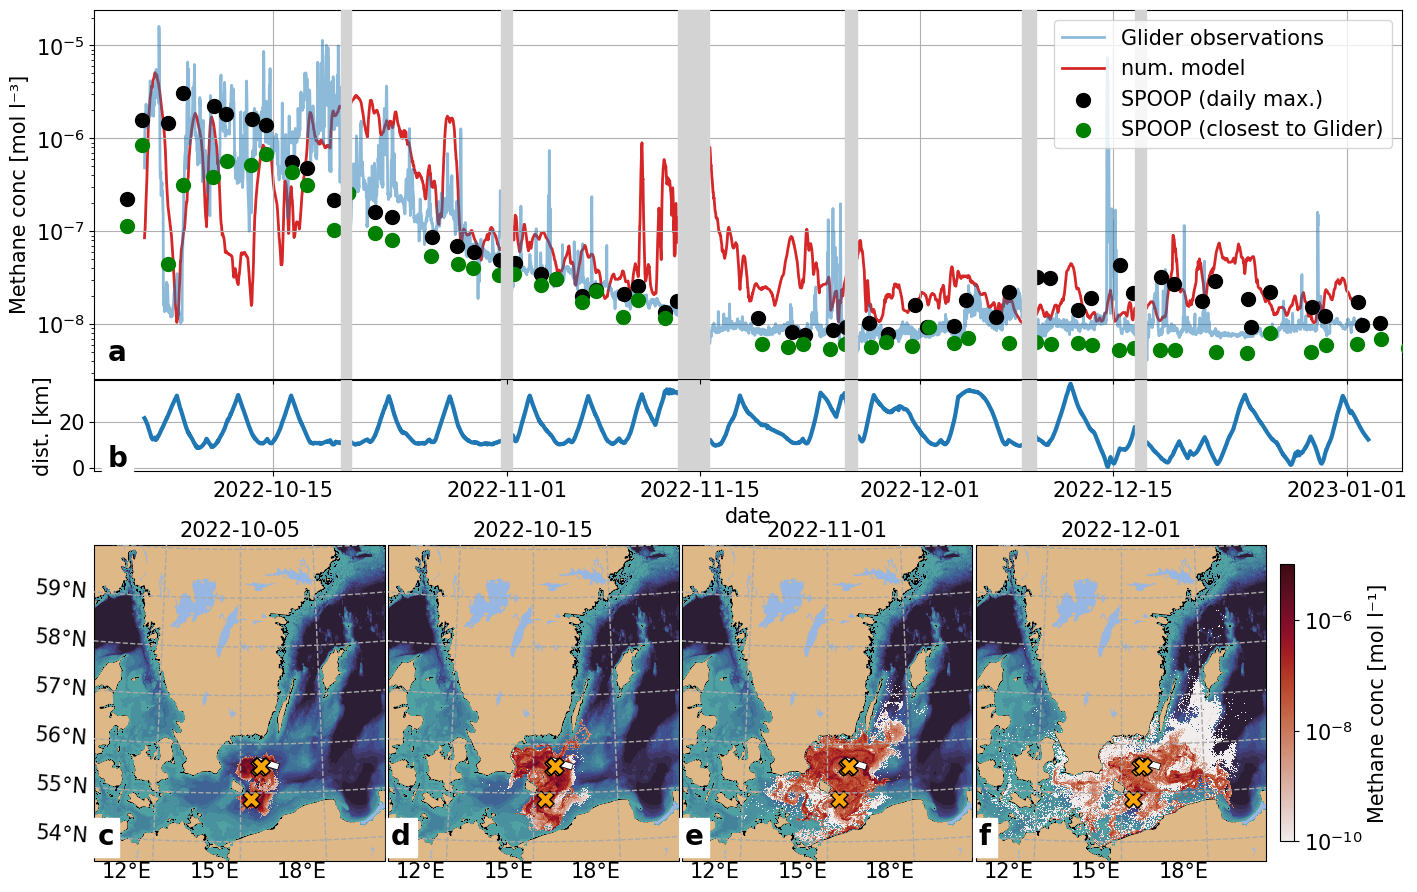

In [8]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(nrows=10, ncols=16, hspace=0.01, wspace=0.05) # hspace, wspace
ax1 = fig.add_subplot(gs[5:10,0:4], projection=coord)
ax2 = fig.add_subplot(gs[5:10,4:8], projection=coord, sharey=ax1)
ax3 = fig.add_subplot(gs[5:10,8:12], projection=coord, sharey=ax1)
ax4 = fig.add_subplot(gs[5:10,12:16], projection=coord, sharey=ax1)
#axc = fig.add_subplot(gs[0:5,16]) # axes for the colorbar creation
axs = [ax1,ax2,ax3,ax4]

axl = fig.add_subplot(gs[4:5,:15])
axu = fig.add_subplot(gs[0:4,:15], sharex=axl)

for n, ax in enumerate([axu, axl, ax1, ax2, ax3, ax4]):
    ax.text(0.01, 0.05, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=20, weight='bold', zorder=100, backgroundcolor='white')

create_2upper(fig, axs)
create_2lower(fig, axu, axl)
plt.setp(axu.get_xticklabels(), visible=False)
plt.tight_layout()
plt.savefig(f'../figures/rf_Figure2_{runnumber}.png', transparent=True)

In [9]:
##################################################
# This cell creates the linear correlation plots #
##################################################

from GliderTools import glidertools as gt
#bathy = xarray.open_dataset("../data/input/BAL-MFC_003_006_mask_bathy.nc")
#bathy = bathy#.sel(longitude=slice(10,20), latitude=slice(53,60.02), drop=True)
#coordinates = xarray.open_dataset("../data/input/BAL-MFC_003_006_coordinates.nc")
#coordinates['areas'] = coordinates.e1t*coordinates.e2t
#coordinates['volumes'] = coordinates.e3t*coordinates.e2t*coordinates.e1t
#subbasins = 'level_2'
#mask = bathy['mask'].values.astype(int)
#np.shape(coordinates['volumes'].values)
#coordinates['volumes'] = coordinates['volumes'].where(mask)

#ds = xarray.open_mfdataset('../data/output/100_histogram.nc', chunks=dict(time=100))
#ds = ds.isel(time=slice(0,-1,1), drop=True) # use this for speedup or approximation

#volumes = coordinates['volumes'].rename(
#    dict(
#        latitude='lat_bin', 
#        longitude='lon_bin',
#        depth='z_bin'))
#ds['volumes'] = (('z_bin', 'lat_bin', 'lon_bin'), volumes.values) # keep this way!
#ds['concentration'] = (ds.mass*1e-6/16.04*1e-3)/ds.volumes # [in ug/m3] 
#ds['concentration'] = ds['concentration']
#ds['concentration_zmean'] = (ds['mass_zsum']*1e-6/16.04*1e-3)/ds.volumes.sum(dim='z_bin')
#ds['concentration_zmean'] = ds['concentration_zmean'].rolling(lon_bin=3, center=True).mean().rolling(lat_bin=3, center=True).mean()

###################################################
# Do the colocation between glider and simulation #
###################################################
import datetime
dsg = xarray.open_mfdataset('../data/input/methane_processed_bastien/timeseries_output.nc')
dsg['meantime'] = gt.utils.time_average_per_dive(dsg.profile_num, dsg.time)

dsgud = dsg
dsgud = dsg.where(dsg.profile_num.values%2==1).dropna(dim='time', subset=['depth'])

dfgud = dsgud.to_pandas()
means = dfgud.groupby('profile_num').mean()
means['background'] = (mutils.compute_methane_equilibrium(means, 'surface')*1e-3).values

from GliderTools import glidertools as gt

result = ds.drop_dims('z_bin')['concentration_zmean'].interp(
    time=means.meantime.to_xarray(),
    lon_bin=means.longitude.to_xarray(),
    lat_bin=means.latitude.to_xarray(),
    method='linear')

result_w_background = result.where(result.values>means.background.values, other=means.background.values)

/media/coffee/T7/Nordstream/code/GliderTools/glidertools/helpers.py:97: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xds = xr.DataArray(


compute_solubility_H returning solubillity in [mol m-3 Pa-1]
compute_methane_equilibrium returning molar
        concentration in [mol m-3]


                                 OLS Regression Results                                
Dep. Variable:                  model   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.875
Method:                 Least Squares   F-statistic:                              6340.
Date:                Tue, 21 Nov 2023   Prob (F-statistic):                        0.00
Time:                        13:31:09   Log-Likelihood:                         -628.33
No. Observations:                 909   AIC:                                      1259.
Df Residuals:                     908   BIC:                                      1263.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

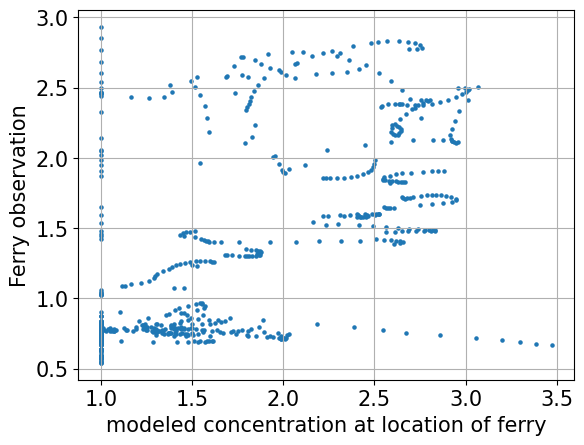

In [10]:
#################################################
# Do the colocation between glider and FerryBox #
#################################################
import pandas
df_ferry = pandas.read_csv(
    '../data/input/IOW_Ferry_box/IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_VOTO/'
    'IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_DLR.txt')
df_ferry['time'] = pandas.to_datetime(df_ferry['MatlabTime']-719529, unit='D')
df_ferry = df_ferry[(df_ferry.Lat>55.3) & (df_ferry.Lat<55.8) & (df_ferry.Lon>15.6) & (df_ferry.Lon<15.8)]

# df_ferry = df_ferry.resample('H', on='time').apply(np.nanmean)#mean()
df_ferry.drop(['MatlabTime', 'ExcelTime', 'Day', 'Month', 'Year', 'Hour', 'Minute'], axis=1)
#starttime = np.datetime64('2022-10-04')
#endtime = np.datetime64('2022-10-07')
#df_ferry = df_ferry[(df_ferry.time<endtime) & (df_ferry.time>starttime)]#.values#.reshape(-1, 1)
df_ferry = df_ferry.dropna()


ferry_result = ds.drop_dims('z_bin')['concentration_zmean'].interp(
    time=df_ferry.time.to_xarray(),
    lon_bin=df_ferry.Lon.to_xarray(),
    lat_bin=df_ferry.Lat.to_xarray(),
)
#ferry_result#.mean().compute()
#result
#plt.plot(df_ferry)
ferry_result_w_background = ferry_result.where(ferry_result.values>1e-8, other=1e-8)
x = np.log10(ferry_result_w_background.values*1e9) # .reshape(-1, 1)
time = ferry_result.time.values

y = np.log10(df_ferry['cCH4is_nmol_l_corr']).values



#(result_w_background[(result_w_background.time<endtime) & (result_w_background.time>starttime)]).values*1e6 #/1e3).values
#y = (ferry_result[(ferry_result.time<endtime) & (ferry_result.time>starttime)]).values*1e6

plt.scatter(x, y, s=5)#, c=df_ferry['time'])
plt.xlabel('modeled concentration at location of ferry')
plt.ylabel('Ferry observation')
plt.grid()
#df_ferry


#x[x>10]=np.nan
df = pd.DataFrame.from_dict({'ferry':x, 'model':y, 'time':time})
df = df.dropna()

import statsmodels.api as sm
#dffiltered = df[(df.glider>cutoff_thresh) & (df.model>cutoff_thresh)]
results = sm.OLS(df.model,df.ferry).fit() # fitting the model
print(results.summary())
A = results.conf_int()
slopemin = A[0].values #95
slopemax = A[1].values #
slope = results.params.ferry

# A note on the correlation plots.

The good correlation is reached with datasets 190 and 191.

190 has a bit poor timeresolution though. 

This is something that I still might want to adress.

What I want/need to do here is to look at 192, correct the amount of methane and rerun the simulation. Might be usefull to include the ranges that fall out of the linear regression plot as uncertainties, maybe also use the PBREAK/CATHARE difference as uncertainty. Then moreover, we add an additional uncertainty for the Glider observations that it is regressed against. 

Reasons why I wouldn't calibrate the total amount of methane by the Ferry:

The Ferry does not measure any concentrations in the depths. Thus, only a fraction of the dissolved methane, which is already affected by outgassing, can be measured. 
The Ferry is passing irregularly
The Ferry traverses the sites relatively quickly, so that a time dependence couldn't be caught. 
The Ferry is not exposed to the majority of the released methane according to our simulation. 

                                 OLS Regression Results                                
Dep. Variable:                  model   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.850
Method:                 Least Squares   F-statistic:                              390.6
Date:                Tue, 21 Nov 2023   Prob (F-statistic):                    6.81e-30
Time:                        13:31:12   Log-Likelihood:                         -120.58
No. Observations:                  69   AIC:                                      243.2
Df Residuals:                      68   BIC:                                      245.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

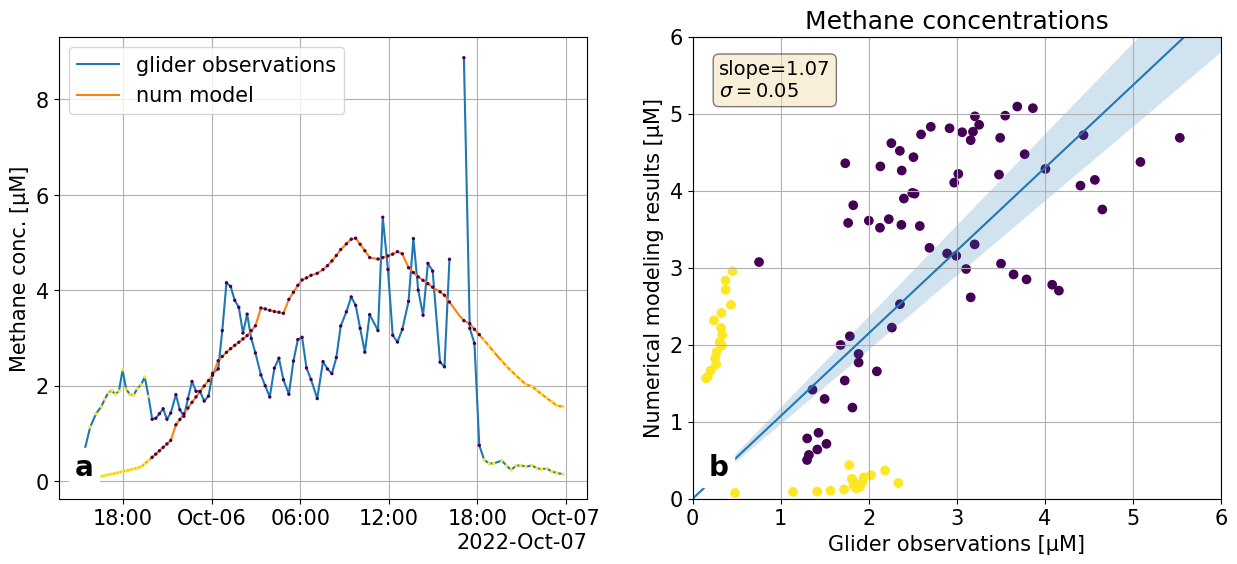

In [11]:
from scipy import stats
import matplotlib.dates as mdates

fig, axs = plt.subplots(figsize=[15,6], ncols=2)

# normal variant
starttime = np.datetime64('2022-10-04')
endtime = np.datetime64('2022-10-07')
cutoff_thresh = 0.5

# full time variant
# starttime = np.datetime64('2022-10-04')
# endtime = np.datetime64('2022-12-31')
# cutoff_thresh = 0.0

x = means.methane[(means.meantime<endtime) & (means.meantime>starttime)].values#.reshape(-1, 1)
time = means.meantime[(means.meantime<endtime) & (means.meantime>starttime)].values
y = (result_w_background[(result_w_background.time<endtime) & (result_w_background.time>starttime)]).values*1e6#-0.01 #/1e3).values
#y = results-10
#y = (ferry_result[(ferry_result.time<endtime) & (ferry_result.time>starttime)]).values*1e6
x[x>10]=np.nan
df = pd.DataFrame.from_dict({'glider':x, 'model':y, 'time':time})
df = df.dropna()

"""
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin = lin.fit(df[['glider']], df['model'])
ax = df.plot.scatter(x='glider', y='model', alpha=.1)
ax.plot(df['model'], lin.predict(df[['glider']]), c='r')
"""

axs[1].scatter(df.glider, df.model, c=((df.glider<cutoff_thresh) | (df.model<cutoff_thresh)) , alpha=1)
axs[1].set_ylim(0,6)
axs[1].set_xlim(0,6)
axs[1].grid()
axs[1].set_title('Methane concentrations')
axs[1].set_xlabel('Glider observations [μM]')
axs[1].set_ylabel('Numerical modeling results [μM]')

#res = stats.linregress(df.glider, df.model)
#print(res.slope)
#print(res.intercept)
#x2 = np.linspace(0,np.max(df.glider))

import statsmodels.api as sm
dffiltered = df[(df.glider>cutoff_thresh) & (df.model>cutoff_thresh)]
results = sm.OLS(dffiltered.model,dffiltered.glider).fit() # fitting the model
print(results.summary())
A = results.conf_int()
slopemin = A[0].values #95
slopemax = A[1].values #
slope = results.params.glider

#from sklearn.linear_model import LinearRegression
#model = LinearRegression(fit_intercept=False)
#model.fit(dffiltered[['glider']], dffiltered['model'])
x2 = np.linspace(0,np.max(df.glider))
axs[1].plot(x2, x2*results.params.glider)
axs[1].fill_between(x2, 
                 x2*(slopemin), 
                 x2*(slopemax),
                alpha=0.2)


textstr = '\n'.join((
    'slope=%.2f' % (slope, ),
    #r'$\mathrm{median}=%.2f$' % (0.052, ),
    r'$\sigma=%.2f$' % (0.052, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)



# fig, ax = plt.subplots(figsize=[15,5])
axs[0].plot(time, x, label='glider observations')
axs[0].plot(time, y, label='num model')
axs[0].scatter(df.time, df.glider,s=2, zorder=3, c=((df.glider<cutoff_thresh) | (df.model<cutoff_thresh)))
axs[0].scatter(df.time, df.model, s=2, zorder=3, c=((df.glider<cutoff_thresh) | (df.model<cutoff_thresh)))

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel('Methane conc. [μM]')

axs[0].legend()
axs[0].grid()

axs[0].text(0.03, 0.05, string.ascii_lowercase[0], transform=axs[0].transAxes, 
        size=20, weight='bold', zorder=100, backgroundcolor='white')
axs[1].text(0.03, 0.05, string.ascii_lowercase[1], transform=axs[1].transAxes, 
        size=20, weight='bold', zorder=100, backgroundcolor='white')

plt.savefig('../figures/supplementary_regression.png')

In [12]:
#results.params.
#head = pd.read_html(results.summary2())[0]
#body = pd.read_html(results.summary2())[1]
results

In [13]:
#dssum = ds.sum(dim=['lat_bin', 'lon_bin'])
#for day in range(0,30):
#    plt.plot(dssum.concentration.isel(time=day), -dssum.concentration.isel(time=day).z_bin)
#    plt.ylim(-200,0)
#plt.pcolormesh(dssum.time, -dssum.z_bin, dssum.mass)
# plt.scatter(df.glider, df.model, c=((df.glider<0.3) | (df.model<0.3)) , alpha=1)

In [14]:
# 160 no degradation
# 170 0.035d-1
# 180 0.5*0.035d-1
# 190 0.0035d-1
"""
rddict = {170:'C1', 180:'C2', 190:'C4'}
rdlabels = {170:'0.035', 180:'0.0175', 190:'0.0035'}
rdlinestyles = {170:'-', 180:'--', 190:'-.'}
fig, axs = plt.subplots(figsize=[20,10], nrows=2, height_ratios=[10,1])
for runnumber in [160, 170, 180, 190]:
    print(f'../data/output/{runnumber}_histogram.nc')
    #ds = xarray.open_mfdataset(f'../data/output/{runnumber}_histogram.nc', chunks=dict(time=10))
    # ds = xarray.open_mfdataset('../data/output/180_histogram.nc', chunks=dict(time=10))

    #ds = ds.isel(time=slice(0,-1,10), drop=True) # use this for speedup or approximation
    #print('ATENTION: SUBSAMPLING SPEEDUP ACTIVE')

    volumes = coordinates['volumes'].rename(
        dict(
            latitude='lat_bin', 
            longitude='lon_bin',
            depth='z_bin'))
    ds['volumes'] = (('z_bin', 'lat_bin', 'lon_bin'), volumes.values) # keep this way!
    ds['concentration'] = ds.mass/ds.volumes # [in ug/m3]
    ds['concentration'] = ds['concentration']*1e-6/16.04*1e-3
    ds['concentration_zmean'] = ds['mass_zsum']*1e-6/16.04*1e-3/ds.volumes.sum(dim='z_bin')
    h = ds['concentration_zmean']
    if runnumber==160: # no degradation
        create_2lower(fig, axs[0], axs[1])
    else:
        create_2lower(fig, axs[0], axs[1], degrationplot=True)
axs[0].grid()
axs[0].legend(loc='upper right').set_zorder(250)
"""

"\nrddict = {170:'C1', 180:'C2', 190:'C4'}\nrdlabels = {170:'0.035', 180:'0.0175', 190:'0.0035'}\nrdlinestyles = {170:'-', 180:'--', 190:'-.'}\nfig, axs = plt.subplots(figsize=[20,10], nrows=2, height_ratios=[10,1])\nfor runnumber in [160, 170, 180, 190]:\n    print(f'../data/output/{runnumber}_histogram.nc')\n    #ds = xarray.open_mfdataset(f'../data/output/{runnumber}_histogram.nc', chunks=dict(time=10))\n    # ds = xarray.open_mfdataset('../data/output/180_histogram.nc', chunks=dict(time=10))\n\n    #ds = ds.isel(time=slice(0,-1,10), drop=True) # use this for speedup or approximation\n    #print('ATENTION: SUBSAMPLING SPEEDUP ACTIVE')\n\n    volumes = coordinates['volumes'].rename(\n        dict(\n            latitude='lat_bin', \n            longitude='lon_bin',\n            depth='z_bin'))\n    ds['volumes'] = (('z_bin', 'lat_bin', 'lon_bin'), volumes.values) # keep this way!\n    ds['concentration'] = ds.mass/ds.volumes # [in ug/m3]\n    ds['concentration'] = ds['concentration']*

In [15]:
import pandas
df_ferry = pandas.read_csv(
    '../data/input/IOW_Ferry_box/IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_VOTO/'
    'IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_DLR.txt')
df_ferry['time'] = pandas.to_datetime(df_ferry['MatlabTime']-719529, unit='D')
df_ferry_close = df_ferry[(df_ferry.Lat>55.3) & (df_ferry.Lat<55.8) & (df_ferry.Lon>15.6) & (df_ferry.Lon<15.8)]

# df_ferry = df_ferry.resample('H', on='time').apply(np.nanmean)#mean()

df_ferry = df_ferry.dropna()
df_ferry.drop(['MatlabTime', 'ExcelTime', 'Day', 'Month', 'Year', 'Hour', 'Minute'], axis=1)
#df_ferry_max = df_ferry.groupby(df_ferry.time.dt.date)[].max()
indices = df_ferry.groupby(df_ferry.time.dt.date)['cCH4is_nmol_l_corr'].idxmax()
df_ferry_max = df_ferry.loc[indices.values]

df_ferry_close = df_ferry_close.dropna()
df_ferry_close.drop(['MatlabTime', 'ExcelTime', 'Day', 'Month', 'Year', 'Hour', 'Minute'], axis=1)
#df_ferry_max = df_ferry.groupby(df_ferry.time.dt.date)[].max()
indices = df_ferry_close.groupby(df_ferry_close.time.dt.date)['cCH4is_nmol_l_corr'].idxmax()
df_ferry_close_max = df_ferry.loc[indices.values]

In [16]:
#df_ferry_close

/media/coffee/T7/Nordstream/code/GliderTools/glidertools/helpers.py:97: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xds = xr.DataArray(
/media/coffee/T7/Nordstream/code/GliderTools/glidertools/helpers.py:97: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be

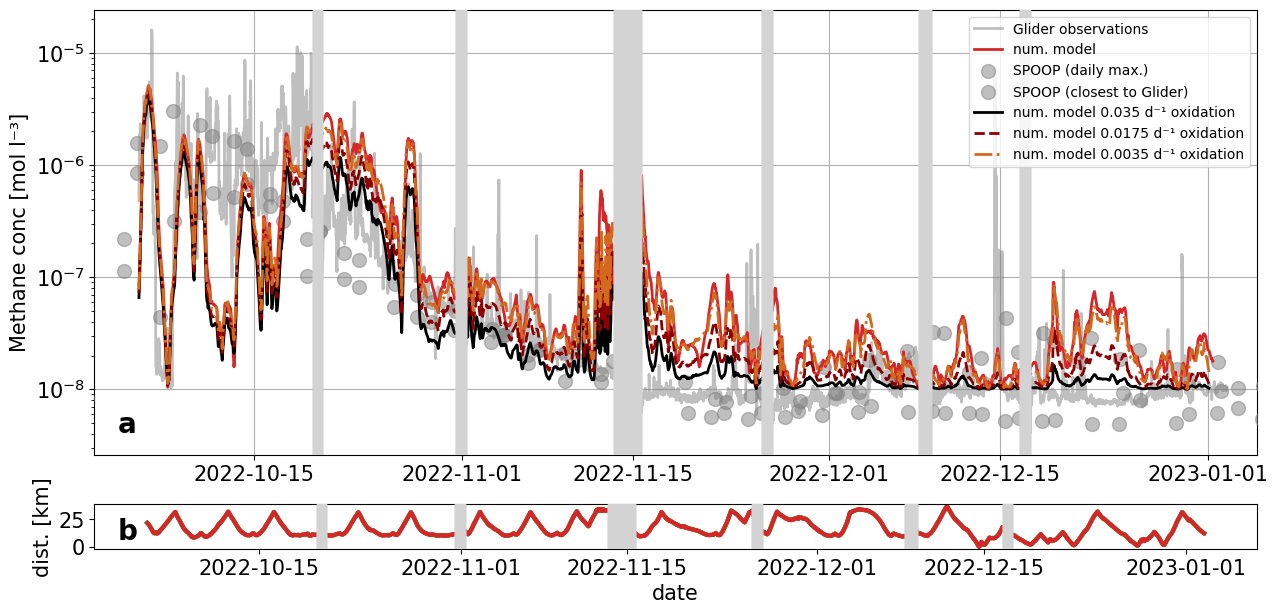

In [17]:
#import pandas

# rddict = {170:'C1', 180:'C2', 190:'C4'}
rddict = {170:'k', 180:'darkred', 190:'chocolate', 194:'darkorange'}
rdlabels = {170:'0.035', 180:'0.0175', 190:'0.0035'}
rdlinestyles = {170:'-', 180:'--', 190:'-.'}
ds = xarray.open_mfdataset(f'../data/output/{runnumber}_histogram.nc', chunks=dict(time=10))

fig, axs = plt.subplots(figsize=[15,7], nrows=2, height_ratios=[10,1])
#runnumber = 160
#ds = xarray.open_mfdataset(f'../data/output/{runnumber}_histogram.nc', chunks=dict(time=10))
volumes = coordinates['volumes'].rename(
    dict(
        latitude='lat_bin', 
        longitude='lon_bin',
        depth='z_bin'))
ds['volumes'] = (('z_bin', 'lat_bin', 'lon_bin'), volumes.values) # keep this way!
ds['concentration'] = ds.mass/ds.volumes # [in ug/m3]
ds['concentration'] = ds['concentration']*1e-6/16.04*1e-3
ds['concentration_zmean'] = ds['mass_zsum']*1e-6/16.04*1e-3/ds.volumes.sum(dim='z_bin')
axs[0] = create_2lower(fig, axs[0], axs[1], everythinggrey=True)

#axs[0].scatter(df_ferry_max.time , df_ferry_max.cCH4is_nmol_l_corr*1e-9, 
#               s=100, c='k', label='FerryBox (daily max.)', zorder=50)
#axs[0].scatter(df_ferry_close_max.time , df_ferry_close_max.cCH4is_nmol_l_corr*1e-9, 
#               s=100, c='green', label='FerryBox (closest to Glider)', zorder=50)

# rddict = {170:'grey', 180:'grey', 190:'grey'}
for looprunnumber in [170, 180, 190]:
    ds = xarray.open_mfdataset(f'../data/output/{looprunnumber}_histogram.nc', chunks=dict(time=10))
    volumes = coordinates['volumes'].rename(
        dict(
            latitude='lat_bin', 
            longitude='lon_bin',
            depth='z_bin'))
    ds['volumes'] = (('z_bin', 'lat_bin', 'lon_bin'), volumes.values) # keep this way!
    ds['concentration'] = ds.mass/ds.volumes # [in ug/m3]
    ds['concentration'] = ds['concentration']*1e-6/16.04*1e-3
    ds['concentration_zmean'] = ds['mass_zsum']*1e-6/16.04*1e-3/ds.volumes.sum(dim='z_bin')
    create_2lower(fig, axs[0], axs[1], degrationplot=True)

ds = xarray.open_mfdataset(f'../data/output/{runnumber}_histogram.nc', chunks=dict(time=10))
axs[0].legend(loc='upper right', fontsize=10).set_zorder(1001)
axs[0].set_yscale('log')
axs[0].grid()

axs[0].text(0.02, 0.05, string.ascii_lowercase[0], transform=axs[0].transAxes, 
        size=20, weight='bold', zorder=100)#, backgroundcolor='white')
axs[1].text(0.02, 0.2, string.ascii_lowercase[1], transform=axs[1].transAxes, 
        size=20, weight='bold', zorder=100)#, backgroundcolor='white')

plt.savefig('../figures/oxidation_rate_sensitivity.png')

In [18]:
#ax.legend()

/media/coffee/T7/Nordstream/code/GliderTools/glidertools/helpers.py:97: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xds = xr.DataArray(


KeyError: 'concentration_zmean'

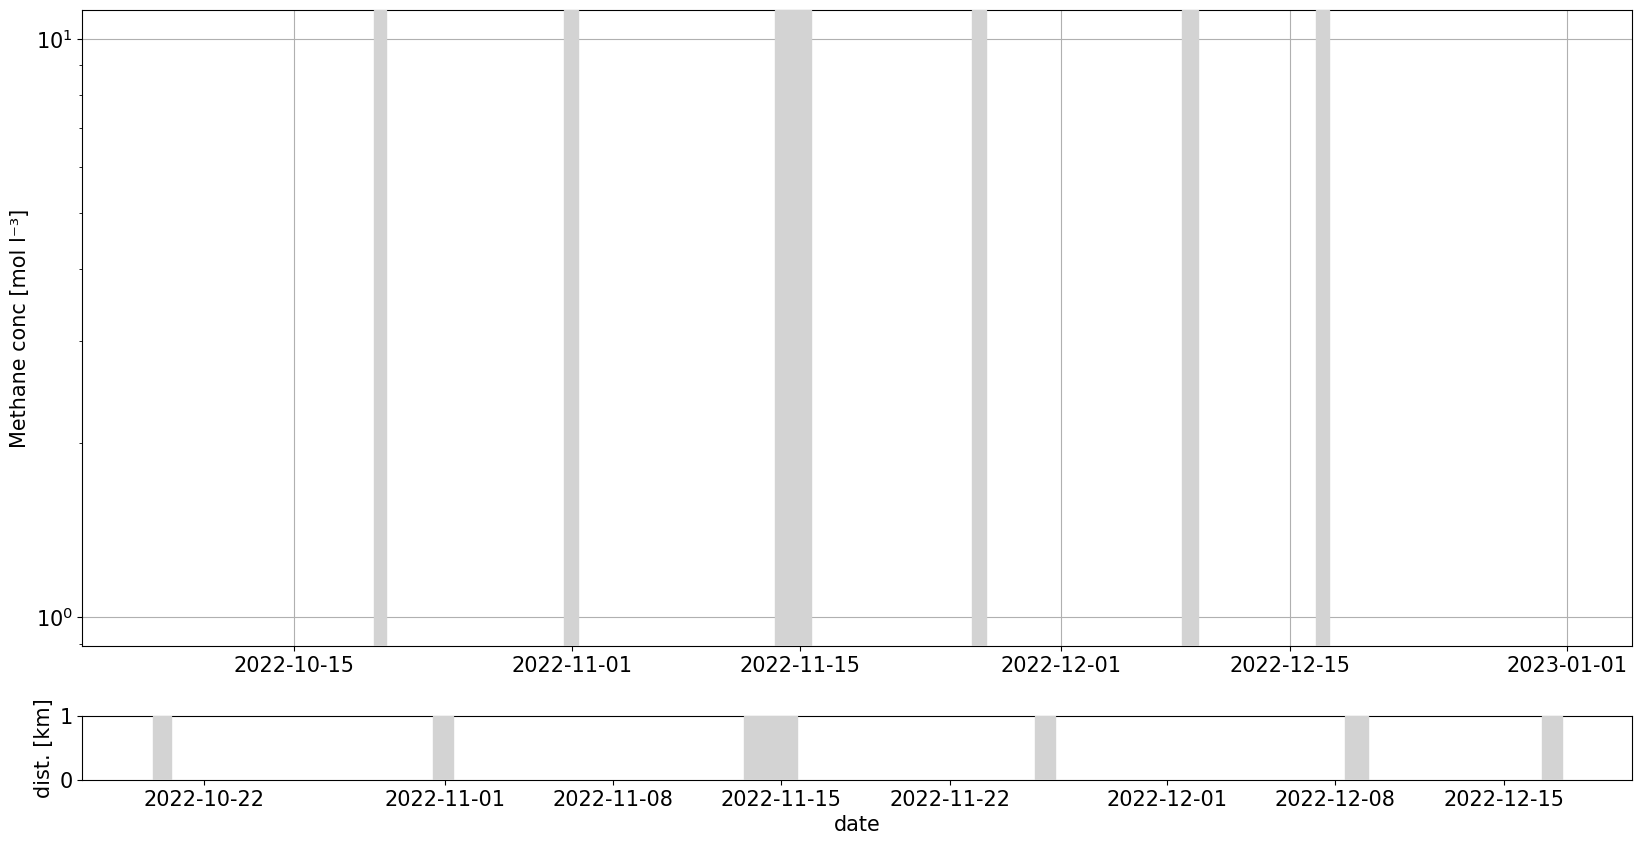

In [19]:
fig, axs = plt.subplots(figsize=[20,10], nrows=2, height_ratios=[10,1])

create_2lower(fig, axs[0], axs[1], degrationplot=True)
create_2lower(fig, axs[0], axs[1], degrationplot=True, surface=True)

In [ ]:
df_ferry_max['glider_longitude'] = dsg.sel(time=df_ferry_max.time.values, method='nearest').longitude.values
df_ferry_max['glider_latitude'] = dsg.sel(time=df_ferry_max.time.values, method='nearest').latitude.values
df_ferry_max['glider_ferry_distance'] = great_circle(df_ferry_max.Lon, df_ferry_max.Lat,
                                                    df_ferry_max.glider_longitude, df_ferry_max.glider_latitude)
plt.plot(df_ferry_max['glider_ferry_distance'])

In [ ]:
ferrytrack_concentration = ds['concentration'].isel(z_bin=1).sel(
    time=df_ferry.time.to_xarray(), 
    lon_bin=df_ferry.Lon.to_xarray(), 
    lat_bin=df_ferry.Lat.to_xarray(), 
    method='nearest')

In [ ]:
from scipy import stats
import matplotlib.dates as mdates

fig, axs = plt.subplots(figsize=[15,6], ncols=2)

# remember that background concentrations can make a difference here
calibration = 'long' # 'long' or 'short'
# normal variant
if calibration=='short':
    starttime = np.datetime64('2022-10-04')
    endtime = np.datetime64('2022-10-07')
    cutoff_thresh = 500#0.5
    x = means.methane[(means.meantime<endtime) & (means.meantime>starttime)].values*1e3#.reshape(-1, 1)
    x[x>7.5e3]=np.nan
    time = means.meantime[(means.meantime<endtime) & (means.meantime>starttime)].values
    y = (result_w_background[(result_w_background.time<endtime) & (result_w_background.time>starttime)]).values*1e9 #/1e3).values
else:
    starttime = np.datetime64('2022-10-04')
    endtime = np.datetime64('2022-12-07')
    cutoff_thresh = -1000.0
    x = np.log10(means.methane[(means.meantime<endtime) & (means.meantime>starttime)].values*1e3)#.reshape(-1, 1)
    x[x>7.5e3]=np.nan
    time = means.meantime[(means.meantime<endtime) & (means.meantime>starttime)].values
    y = np.log10((result_w_background[(result_w_background.time<endtime) & (result_w_background.time>starttime)]).values*1e9) #/1e3).values

#x = np.log10(means.methane[(means.meantime<endtime) & (means.meantime>starttime)].values*1e3)#.reshape(-1, 1)
#time = means.meantime[(means.meantime<endtime) & (means.meantime>starttime)].values
#y = np.log10((result_w_background[(result_w_background.time<endtime) & (result_w_background.time>starttime)]).values*1e9) #/1e3).values
# y = np.log10(ferry_result[(ferry_result.time<endtime) & (ferry_result.time>starttime)]).values*1e6

df = pd.DataFrame.from_dict({'glider':x, 'model':y, 'time':time})
df = df.dropna()

"""
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin = lin.fit(df[['glider']], df['model'])
ax = df.plot.scatter(x='glider', y='model', alpha=.1)
ax.plot(df['model'], lin.predict(df[['glider']]), c='r')
"""

axs[1].scatter(x, y)#df.glider, df.model, c=((df.glider<cutoff_thresh) | (df.model<cutoff_thresh)) , alpha=1)
#axs[1].set_ylim(0,6)
#axs[1].set_xlim(0,6)
axs[1].grid()
axs[1].set_title('Methane concentrations')
axs[1].set_xlabel('Glider observations [μM]')
axs[1].set_ylabel('Numerical modeling results [μM]')
# axs[1].se

#res = stats.linregress(df.glider, df.model)
#print(res.slope)
#print(res.intercept)
#x2 = np.linspace(0,np.max(df.glider))

import statsmodels.api as sm
dffiltered = df[(df.glider>cutoff_thresh) & (df.model>cutoff_thresh)]
results = sm.OLS(dffiltered.glider,dffiltered.model).fit() # fitting the model 
print(results.summary())
A = results.conf_int()#[0]
slopemin = A[0]#.values #95
slopemax = A[1]#.values #
slope = results.params[0]

#from sklearn.linear_model import LinearRegression
#model = LinearRegression(fit_intercept=False)
#model.fit(dffiltered[['glider']], dffiltered['model'])
x2 = np.linspace(np.min(dffiltered.glider),np.max(dffiltered.glider)) # hier entscheidet sich, ob wir einen offset haben oder nicht
axs[1].plot(x2, x2*results.params[0], color='k')
axs[1].fill_between(x2, 
                 x2*slopemin.values, 
                 x2*slopemax.values,
                 alpha=0.2)


textstr = '\n'.join((
    'slope=%.2f' % (slope, ),
    #r'$\mathrm{median}=%.2f$' % (0.052, ),
    r'$\sigma=%.2f$' % (0.052, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes, fontsize=14, verticalalignment='top', bbox=props)
"""


# fig, ax = plt.subplots(figsize=[15,5])
#axs[0].plot(time, x, label='glider observations')
#axs[0].plot(time, y, label='num model')
#axs[0].scatter(df.time, df.glider,s=2, zorder=3, c=((df.glider<cutoff_thresh) | (df.model<cutoff_thresh)))
#axs[0].scatter(df.time, df.model, s=2, zorder=3, c=((df.glider<cutoff_thresh) | (df.model<cutoff_thresh)))

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel('Methane conc. [μM]')

axs[0].legend()
axs[0].grid()

axs[0].text(0.03, 0.05, string.ascii_lowercase[0], transform=axs[0].transAxes, 
        size=20, weight='bold', zorder=100, backgroundcolor='white')
axs[1].text(0.03, 0.05, string.ascii_lowercase[1], transform=axs[1].transAxes, 
        size=20, weight='bold', zorder=100, backgroundcolor='white')

plt.savefig('../figures/supplementary_regression.png')
"""

In [ ]:
#dffiltered[50:100]
#results = sm.OLS(dffiltered.glider,dffiltered.model).fit()
#print(results.summary())
#A = results.conf_int()[0]
#A
#slopemin.values
#np.min(dffiltered.glider)
10.9*1.06

In [ ]:
x = np.linspace(1,10,10)
y = x + np.random.rand(len(x))
plt.scatter(x,y)

In [ ]:
import statsmodels.api as sm
#dffiltered = df[(df.glider>cutoff_thresh) & (df.model>cutoff_thresh)]
results = sm.OLS(np.log(x*10),np.log(y*10)).fit() # fitting the model
print(results.summary())
A = results.conf_int()[0]
slopemin = A[0]#.values #95
slopemax = A[1]#.values #
slope = results.params[0]

In [ ]:
x = means.methane[(means.meantime<endtime) & (means.meantime>starttime)].values*1e3#.reshape(-1, 1)
time = means.meantime[(means.meantime<endtime) & (means.meantime>starttime)].values
y = (result_w_background[(result_w_background.time<endtime) & (result_w_background.time>starttime)]).values*1e9 #/1e3).values
plt.scatter(x,y/x, alpha=0.1)
plt.ylim(0,5)
plt.xlim(0,100)
plt.grid()

In [ ]:
#x
#x[x>10]=np.nan
#x

In [ ]:
# CHecking what distance from the Leak sites the ferry is passing, and the Glider is deployed
import dictionaries
import pandas
import numpy as np
import xarray
from matplotlib import pyplot as plt
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1)
                  * np.cos(lat2) * np.cos(lon1 - lon2))
    )

dsg = xarray.open_mfdataset('../data/input/methane_processed_bastien/timeseries_output.nc')
df_ferry = pandas.read_csv(
    '../data/input/IOW_Ferry_box/IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_VOTO/'
    'IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_DLR.txt')
distance = great_circle(df_ferry['Lon'], df_ferry['Lat'], dictionaries.leak2['lon'], dictionaries.leak2['lat'])
plt.plot(distance)
plt.ylim(0,50)
plt.grid()

In [ ]:
distance = great_circle(dsg['longitude'], dsg['latitude'], dictionaries.leak4['lon'], dictionaries.leak4['lat'])
plt.plot(distance)
plt.ylim(0,50)
plt.grid()

In [ ]:
#ds = xarray.open_mfdataset(f'../data/output/194_histogram.nc', chunks=dict(time=10))
#dssum = ds.sum(dim=['lon_bin', 'lat_bin', 'z_bin']).compute()
#plt.plot(dssum.time, dssum.mass)

for looprunnumber in [170, 180, 190]:
    ds = xarray.open_mfdataset(f'../data/output/{looprunnumber}_histogram.nc', chunks=dict(time=10))
    dssum = ds.sum(dim=['lon_bin', 'lat_bin', 'z_bin']).compute()
    plt.plot(dssum.mass_volatilized, color='blue')
    plt.plot(dssum.mass, color='k')
    plt.plot(dssum.mass+dssum.mass_volatilized, color='red')
    #plt.plot(dssum.time, dssum.mass)

In [ ]:
for looprunnumber in [194]:
    ds = xarray.open_mfdataset(f'../data/output/{looprunnumber}_histogram.nc', chunks=dict(time=10))
    dssum = ds.sum(dim=['lon_bin', 'lat_bin', 'z_bin']).compute()
    plt.plot(dssum.mass_volatilized, color='blue')
    plt.plot(dssum.mass, color='k')
    plt.plot(dssum.mass+dssum.mass_volatilized, color='red')
    # plt.plot(dssum.time, dssum.mass)

In [ ]:
ds['mass_biodegraded'] = 

In [ ]:
plt.plot(dssum.mass)
plt.plot(dssum.mass+dssum.mass_volatilized.cumsum())

In [ ]:
plt.plot(dssum.mass_volatilized)

In [ ]:
# dssum.mass_volatilized.cumsum()